In [1]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [4]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


fashion


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


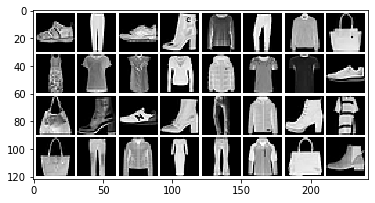

torch.Size([32, 1, 28, 28])


In [5]:
### LOAD DATA ###
dataset = 'fashion'
dataloader, imsize = load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [6]:
def poisson_noise(magn, device, alpha=1):
    intens = magn ** 2
    alpha_2 = alpha ** 2
    lmd = intens / alpha_2
    intens_noise = alpha_2 * torch.distributions.poisson.Poisson(lmd).sample()
    magn_noise = torch.sqrt(intens_noise)
    return magn_noise


def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

# Function to compute test images

def test_generator(model, device, testloader, alpha):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        magn = poisson_noise(calc_mags(data), device, alpha)
        net_input = torch.cat([z, magn], dim=1)
        ouput = model(net_input)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(outputs), np.concatenate(test_images)

In [13]:
### LOAD MODEL ####

gen = models.FCNet(imsize=(2, 28, 28), outsize=imsize, h=2048)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
#disc = models.ConvDiscriminatorSmall(imsize=(2, 28, 28), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/cGAN_Fashion/FCGenerator2048Fashion_4.sd", map_location={'cuda:0': device.__str__()}));
#disc.load_state_dict(torch.load("../cache/cGAN/ConvDiscriminator64MNIST_{}.sd".format(model_nr), map_location={'cuda:1': device.__str__()}));

Version 0.4


In [50]:
# Calculate test predictions 

alpha = 50.0

test_predicted, test_original = test_generator(gen, device, dataloader['test'], alpha=alpha)
print(test_predicted.shape)

(8000, 1, 28, 28)


In [51]:
### CACHE RESULTS ###

import pickle
pickle.dump(test_original, open("/home/shared/phase-retrieval/test/cGAN_Fashion/cganrand_original_1024_alpha{}.p".format(alpha), "wb"))
pickle.dump(test_predicted, open("/home/shared/phase-retrieval/test/cGAN_Fashion/cganrand_1024_alpha{}.p".format(alpha), "wb"))

In [52]:
### LOAD RESULTS ###
import pickle

test_original = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_Fashion/cganrand_original_1024_alpha{}.p".format(alpha), "rb"))
test_predicted = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_Fashion/cganrand_1024_alpha{}.p".format(alpha), "rb"))

Original mean 4.2870917320251465
Noise mean 1.35902738571167
Mean Std: 6.2807693
Mean SNR: 0.6840431
6.281 | 0.684 |


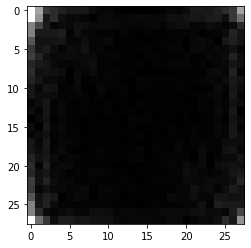

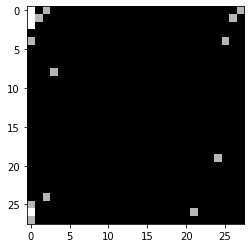

In [53]:
magn = calc_mags(torch.tensor(test_original))
magn_noise = poisson_noise(magn, device, alpha=alpha)

mean_orig = torch.mean(magn).item()
mean_noise = torch.mean(magn_noise).item()
print("Original mean", mean_orig)
print("Noise mean", mean_noise)

means_orig = np.mean(magn.cpu().numpy(), axis=(-1, -2))
errs = magn_noise - magn
stds = np.std(errs.cpu().numpy(), axis=(-1, -2))
print("Mean Std:", np.mean(stds))
print("Mean SNR:", np.mean(means_orig / stds))
print("{:.3f}".format(np.mean(stds)), "|", "{:.3f}".format(np.mean(means_orig / stds)), "|")

plot(magn[0].cpu().numpy() / 70)
plot(magn_noise[0].cpu().numpy() / 70)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


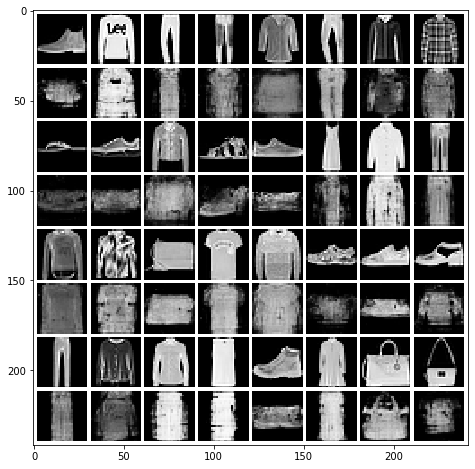

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


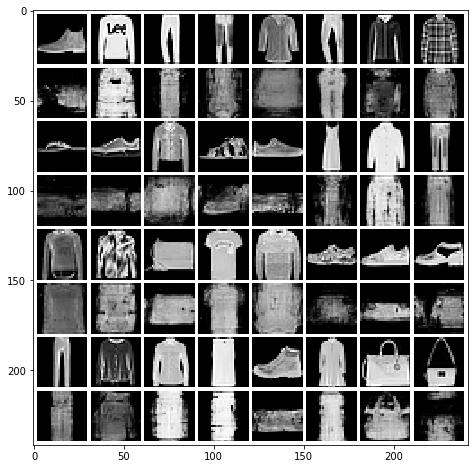

In [54]:
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/cgan/fashion/FCGenerator2048MNIST_alpha{}.png".format(alpha))

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/cgan/fashion/FCGenerator2048MNIST_alpha{}_reg.png".format(alpha))

In [55]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.06028778739437257, std: 0.03132916134416055
  MAE: 0.14873085005092435, std: 0.04764620414858397
  SSIM: 0.36025308233678066, std: 0.15716033804409793
  Sharpness: 0.1801812916407861, std: 0.04612556498188728
  PhCo-MSE: 0.09227789378110174, std: 0.08292132636391938
  PhCo-MAE: 0.1918115390908497, std: 0.10512935977146336
  PhCo-SSIM: 0.3026905175758269, std: 0.18870666673103528
  CroCo-MSE: 0.04848410005433834, std: 0.021148967369535192
  CroCo-MAE: 0.1332891218153236, std: 0.03787180291420316
  CroCo-SSIM: 0.420610199156783, std: 0.13821192866889803

Magnitude error:
  MSE Magnitude: 17.189166706086024, std: 7.640803060793871

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.06029 | 0.1487 | 0.3603 | 0.1802 | 0.09228 | 0.1918 | 0.3027 | 0.04848 | 0.1333 | 0.4206 | 17.19 |


## Evaluation for different cGAN models (random z and 1024 samples)

| Nr | alpha | Mean std_noise (magn) | Mean SNR (magn) | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 4 | 0.1 | 0.050 | 85.460 | 0.01760 | 0.06073 | 0.7561 | 0.1149 | 0.01768 | 0.06115 | 0.7591 | 0.01512 | 0.05723 | 0.7752 | 3.363 |
| 4 | 0.3 | 0.154 | 27.824 | 0.01758 | 0.06070 | 0.7565 | 0.1148 | 0.01807 | 0.06162 | 0.7600 | 0.01510 | 0.05719 | 0.7753 | 3.363 |
| 4 | 1.0 | 0.543 | 7.904 | 0.01768 | 0.06106 | 0.7543 | 0.1140 | 0.01779 | 0.06151 | 0.7582 | 0.01505 | 0.05734 | 0.7742 | 3.400 |
| 4 | 3.0 | 1.472 | 2.903 | 0.01854 | 0.06464 | 0.7326 | 0.1157 | 0.01920 | 0.06590 | 0.7332 | 0.01573 | 0.06059 | 0.7540 | 3.898 |
| 4 | 10.0 | 3.202 | 1.329 | 0.02745 | 0.08681 | 0.6198 | 0.1367 | 0.03063 | 0.09258 | 0.6043 | 0.02317 | 0.08078 | 0.6500 | 6.976 |
| 4 | 25.0 | 4.872 | 0.875 | 0.04389 | 0.1203 | 0.4651 | 0.1640 | 0.06298 | 0.1479 | 0.4159 | 0.03624 | 0.1098 | 0.5101 | 12.00 |
| 4 | 50.0 | 6.281 | 0.684 | 0.06029 | 0.1487 | 0.3603 | 0.1802 | 0.09228 | 0.1918 | 0.3027 | 0.04848 | 0.1333 | 0.4206 | 17.19 |


In [57]:
# Latent z optimization

def genopt(sample_magnitudes, gen, disc, device, init_x=None, max_steps=5000, max_loss=0.0, mue=1.0, lr=1.0):
    
    if disc is not None:
        disc.to(device)
        disc.eval()
    gen.to(device)
    gen.eval()
    
    if init_x is None:
        z = torch.randn((sample_magnitudes.shape), requires_grad=True, device=device)
    else:
        raise NotImplementedError
    
    optimizer = optim.Adam([z], lr=lr)
    
    losses = []
    last_out = gen(torch.cat([z, sample_magnitudes], dim=1))
    
    for i in range(max_steps):
        magnitudes = calc_mags(last_out)

        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=(1, 2, 3))
        reconstruction = torch.sum(mse_all)
        #adversarial = -torch.mean(torch.log(disc(torch.cat([last_out, sample_magnitudes], dim=1))))
        #loss = reconstruction + mue * adversarial
        loss = reconstruction + mue * torch.mean(z ** 2)
        
        if loss < max_loss:
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = gen(torch.cat([z, sample_magnitudes], dim=1))
        
        losses.append(loss.item())
    
    return last_out.detach(), losses, mse_all

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


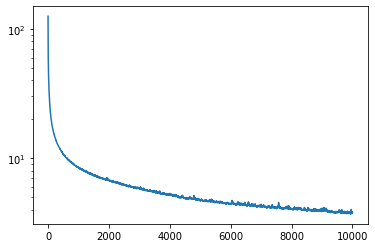

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


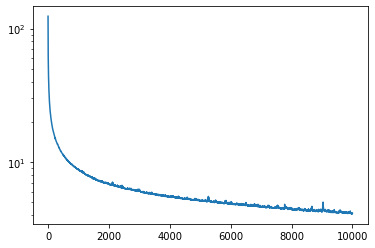

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


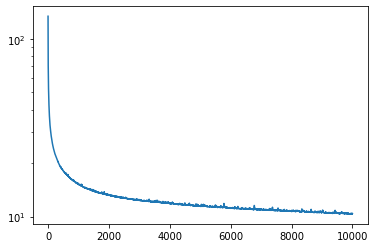

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


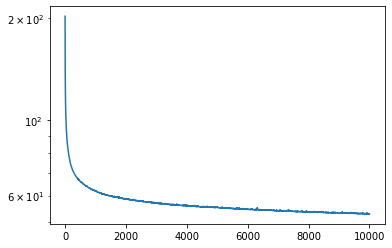

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


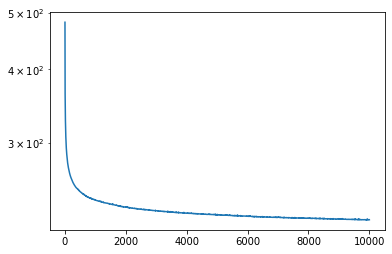

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


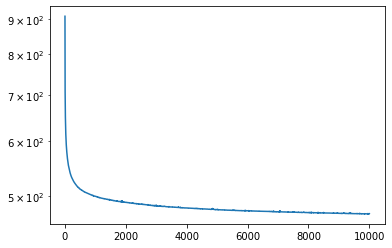

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


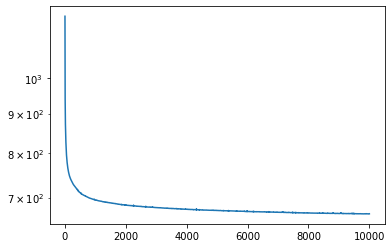

In [58]:
### Latent z optimization ###

alphas = [0.1, 0.3, 1.0, 3.0, 10.0, 25.0, 50.0]

for alpha in alphas:

    num_batches = 32
    batch_size = 32
    max_steps = 10000
    max_loss = 0.0
    mue = 0.0
    lr = 1.0

    ###

    out_original = np.zeros((batch_size * num_batches, *imsize))
    out_results = np.zeros((batch_size * num_batches, *imsize))
    mse_all = np.full((batch_size * num_batches), np.inf)

    for batch_i, batch in enumerate(dataloader['test']):
        test_sample = batch.to(device)  
        test_magnitudes = poisson_noise(calc_mags(test_sample), device, alpha)
        out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()


        cur_out_results, cur_loss, cur_mse_all = genopt(sample_magnitudes=test_magnitudes, gen=gen, disc=None, device=device,
                                              max_steps=max_steps, max_loss=max_loss, mue=mue, lr=lr)
        cur_out_results = cur_out_results.cpu().numpy()

        out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
        mse_all[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_mse_all.detach().cpu().numpy()

        print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
        if batch_i + 1 >= num_batches:
            break

    plt.semilogy(cur_loss)
    plt.show()
    
    # down here repeating savings:
    ###############################
    
    import pickle
    pickle.dump(out_original, open("/home/shared/phase-retrieval/test/cGAN_Fashion/cgan_original_1024_alpha{}.p".format(alpha), "wb"))
    pickle.dump(out_results, open("/home/shared/phase-retrieval/test/cGAN_Fashion/cgan_1024_alpha{}.p".format(alpha), "wb"))


In [ ]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/cGAN_Fashion/cgan_original_1024_alpha{}.p".format(alpha), "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/cGAN_Fashion/cgan_1024_alpha{}.p".format(alpha), "wb"))

In [77]:
### LOAD RESULTS ###
import pickle

alpha = 50.0

out_original = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_Fashion/cgan_original_1024_alpha{}.p".format(alpha), "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_Fashion/cgan_1024_alpha{}.p".format(alpha), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


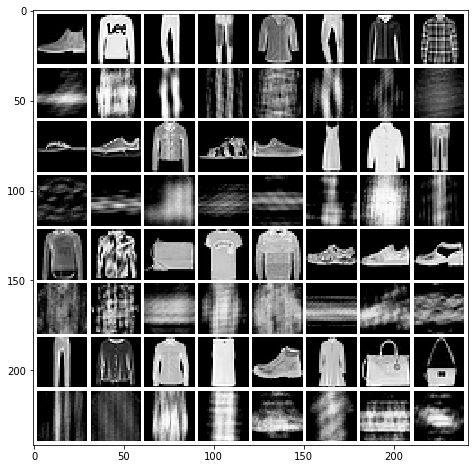

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


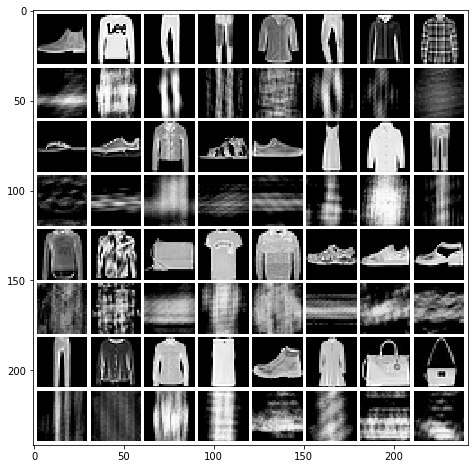

In [78]:
# Print predictions #
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8),
          file="../out/cgan/fashion/FCGenerator2048MNIST_alpha{}_1024_10000latentSteps.png".format(alpha))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8),
          file="../out/cgan/fashion/FCGenerator2048MNIST_alpha{}_1024_10000latentSteps_reg.png".format(alpha))

In [79]:
# Benchmark test predictions #

benchmark(pred=out_results[:1024], true=out_original[:1024], check_all=True)

Signal error:
  MSE: 0.05980700208089094, std: 0.03060605354194969
  MAE: 0.1572511355761399, std: 0.04772892605502263
  SSIM: 0.3400960612968098, std: 0.1585870821611362
  Sharpness: 0.17937520542786872, std: 0.04745668380455717
  PhCo-MSE: 0.12139671442146312, std: 0.0990053784495486
  PhCo-MAE: 0.2374852951492633, std: 0.12156842400349639
  PhCo-SSIM: 0.21502989043925533, std: 0.18454775425282963
  CroCo-MSE: 0.04640463270085034, std: 0.019601778433601356
  CroCo-MAE: 0.13922147662104564, std: 0.03748293525992865
  CroCo-SSIM: 0.4249412970507774, std: 0.12006845261207029

Magnitude error:
  MSE Magnitude: 20.23550692054387, std: 6.692536096738123

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.05981 | 0.1573 | 0.3401 | 0.1794 | 0.1214 | 0.2375 | 0.2150 | 0.04640 | 0.1392 | 0.4249 | 20.24 |


## Final Evaluation (1024 samples)

| Nr | alpha | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 4 | 0.1 | 0.01485 | 0.05066 | 0.8097 | 0.08703 | 0.009961 | 0.04292 | 0.8511 | 0.008514 | 0.04070 | 0.8605 | 0.08758 |
| 4 | 0.3 | 0.01506 | 0.05118 | 0.8079 | 0.08753 | 0.009852 | 0.04297 | 0.8503 | 0.008629 | 0.04111 | 0.8589 | 0.09428 |
| 4 | 1.0 | 0.01523 | 0.05317 | 0.7988 | 0.09164 | 0.01021 | 0.04524 | 0.8403 | 0.008915 | 0.04323 | 0.8492 | 0.1790 |
| 4 | 3.0 | 0.01772 | 0.06365 | 0.7472 | 0.1092 | 0.01239 | 0.05578 | 0.7904 | 0.01113 | 0.05368 | 0.7992 | 0.8596 |
| 4 | 10.0 | 0.02852 | 0.09333 | 0.5978 | 0.1451 | 0.03121 | 0.09892 | 0.5867 | 0.02128 | 0.08303 | 0.6502 | 4.493 |
| 4 | 25.0 | 0.04548 | 0.1285 | 0.4442 | 0.1681 | 0.08462 | 0.1820 | 0.3323 | 0.03415 | 0.1127 | 0.5184 | 11.38 |
| 4 | 50.0 | 0.05981 | 0.1573 | 0.3401 | 0.1794 | 0.1214 | 0.2375 | 0.2150 | 0.04640 | 0.1392 | 0.4249 | 20.24 |